## Road Accident Severity Classification

In [1]:
#import the necessary Libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import Counter
from imblearn.over_sampling import SMOTE
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_auc_score,f1_score,roc_curve
from sklearn.model_selection import KFold # import KFold
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df = pd.read_csv("datasetroad/RTA Dataset.csv")

In [3]:
for c in df.columns:
    print(c, df[c].unique()[:3])

Time ['17:02:00' '1:06:00' '14:15:00']
Day_of_week ['Monday' 'Sunday' 'Friday']
Age_band_of_driver ['18-30' '31-50' 'Under 18']
Sex_of_driver ['Male' 'Female' 'Unknown']
Educational_level ['Above high school' 'Junior high school' nan]
Vehicle_driver_relation ['Employee' 'Unknown' 'Owner']
Driving_experience ['1-2yr' 'Above 10yr' '5-10yr']
Type_of_vehicle ['Automobile' 'Public (> 45 seats)' 'Lorry (41?100Q)']
Owner_of_vehicle ['Owner' 'Governmental' nan]
Service_year_of_vehicle ['Above 10yr' '5-10yrs' nan]
Defect_of_vehicle ['No defect' nan '7']
Area_accident_occured ['Residential areas' 'Office areas' '  Recreational areas']
Lanes_or_Medians [nan 'Undivided Two way' 'other']
Road_allignment ['Tangent road with flat terrain' nan
 'Tangent road with mild grade and flat terrain']
Types_of_Junction ['No junction' 'Y Shape' 'Crossing']
Road_surface_type ['Asphalt roads' 'Earth roads' nan]
Road_surface_conditions ['Dry' 'Wet or damp' 'Snow']
Light_conditions ['Daylight' 'Darkness - lights li

## Let's take a look at the dataset

In [4]:
# convert the 'Date' column to datetime format
df['Time']= pd.to_datetime(df['Time'])

In [5]:
df.duplicated()

0        False
1        False
2        False
3        False
4        False
         ...  
12311    False
12312    False
12313    False
12314    False
12315    False
Length: 12316, dtype: bool

In [6]:
df.groupby('Accident_severity').size()

Accident_severity
Fatal injury        158
Serious Injury     1743
Slight Injury     10415
dtype: int64

### Data Preprocessing

In [7]:
df.isnull().sum()

Time                              0
Day_of_week                       0
Age_band_of_driver                0
Sex_of_driver                     0
Educational_level               741
Vehicle_driver_relation         579
Driving_experience              829
Type_of_vehicle                 950
Owner_of_vehicle                482
Service_year_of_vehicle        3928
Defect_of_vehicle              4427
Area_accident_occured           239
Lanes_or_Medians                385
Road_allignment                 142
Types_of_Junction               887
Road_surface_type               172
Road_surface_conditions           0
Light_conditions                  0
Weather_conditions                0
Type_of_collision               155
Number_of_vehicles_involved       0
Number_of_casualties              0
Vehicle_movement                308
Casualty_class                    0
Sex_of_casualty                   0
Age_band_of_casualty              0
Casualty_severity                 0
Work_of_casuality           

### Numerical data analysis

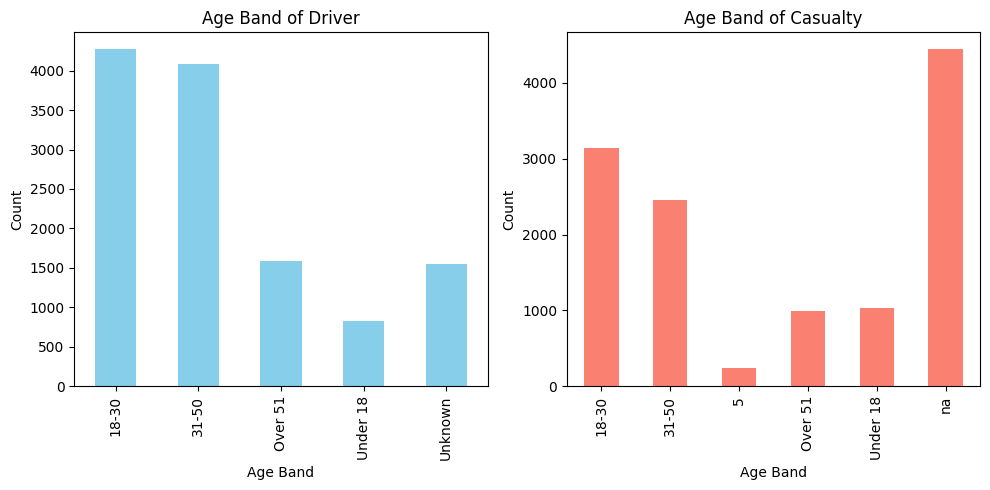

In [8]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
df['Age_band_of_driver'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Age Band of Driver')
plt.xlabel('Age Band')
plt.ylabel('Count')

# Age_band_of_casualty
plt.subplot(1, 2, 2)
df['Age_band_of_casualty'].value_counts().sort_index().plot(kind='bar', color='salmon')
plt.title('Age Band of Casualty')
plt.xlabel('Age Band')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

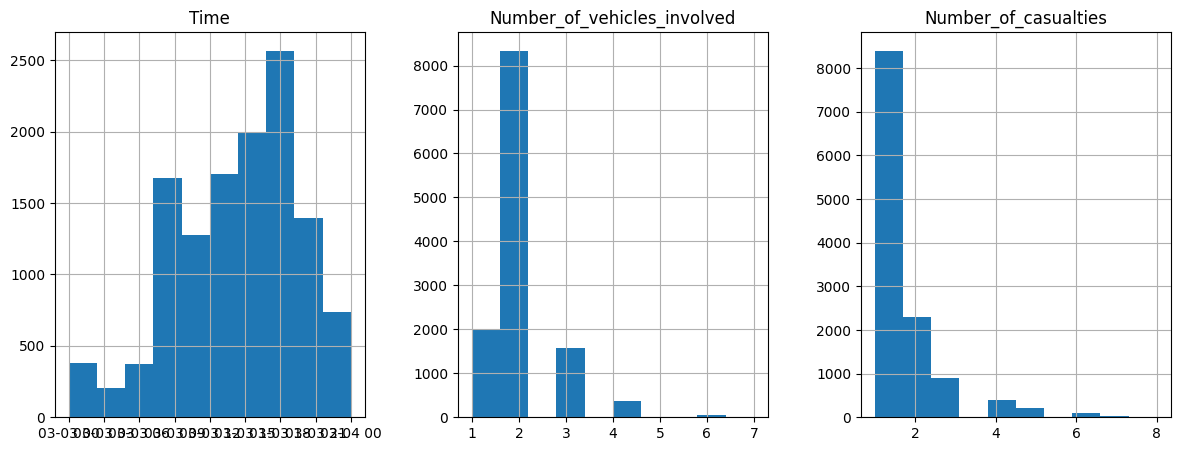

In [9]:
df.hist(layout=(1,6), figsize=(30,5))
plt.show()

In [10]:
df['Number_of_casualties'].value_counts()

Number_of_casualties
1    8397
2    2290
3     909
4     394
5     207
6      89
7      22
8       8
Name: count, dtype: int64

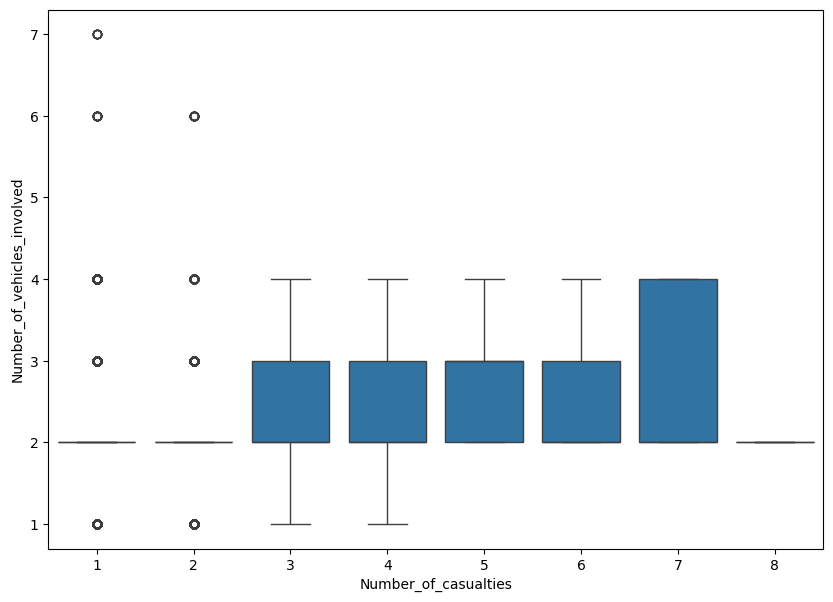

In [11]:
plt.figure(figsize=(10,7))
sns.boxplot(data=df, y='Number_of_vehicles_involved', x='Number_of_casualties')
plt.show()

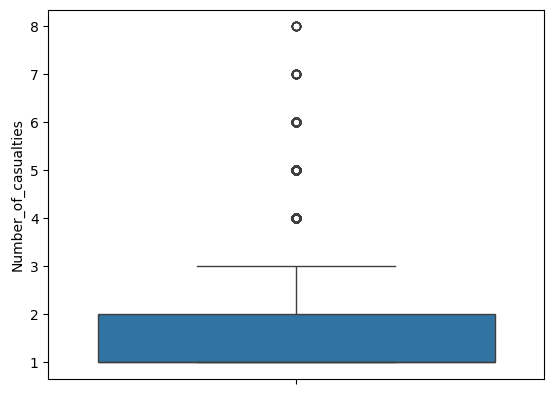

In [12]:
sns.boxplot(data=df, y='Number_of_casualties')
plt.show()

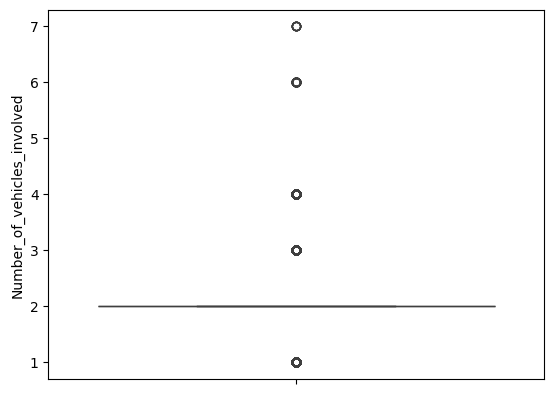

In [13]:
sns.boxplot(data=df, y='Number_of_vehicles_involved')
plt.show()

In [14]:
df['Number_of_vehicles_involved']

0        2
1        2
2        2
3        2
4        2
        ..
12311    2
12312    2
12313    1
12314    2
12315    2
Name: Number_of_vehicles_involved, Length: 12316, dtype: int64

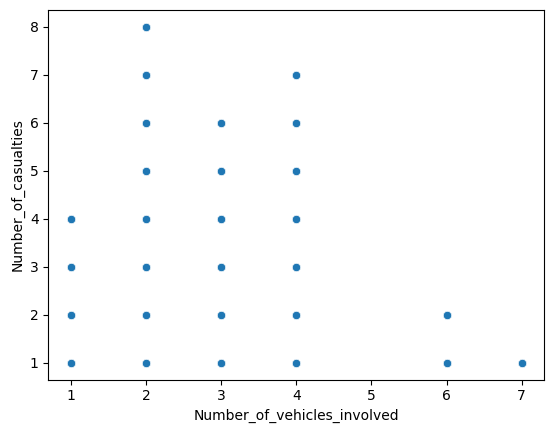

In [15]:
sns.scatterplot(x=df['Number_of_vehicles_involved'], y=df['Number_of_casualties'])
plt.show()

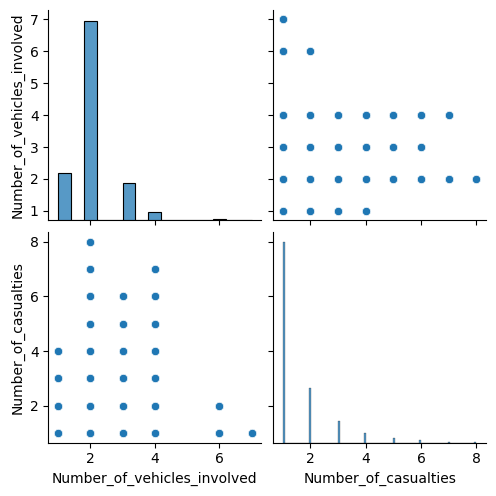

In [16]:
sns.pairplot(df[['Number_of_vehicles_involved','Number_of_casualties']])
plt.show()

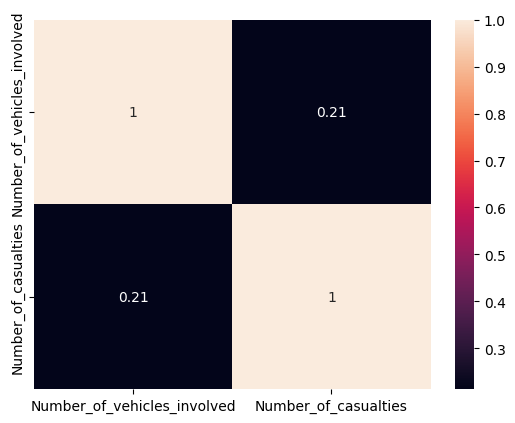

In [17]:
correlation_matrix = df[['Number_of_vehicles_involved','Number_of_casualties']].corr()
sns.heatmap(correlation_matrix, annot=True)
plt.show()

### Observation
In this heatmap, we can find that these are not much extremely correlated variables

### Categorical data analysis

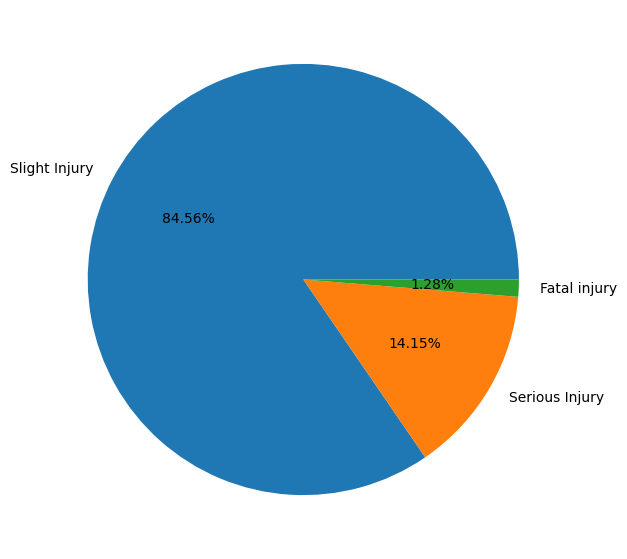

In [18]:
plt.figure(figsize=(10,7))
plt.pie(x=df['Accident_severity'].value_counts().values,
        labels=df['Accident_severity'].value_counts().index,
        autopct='%2.2f%%')
plt.show()

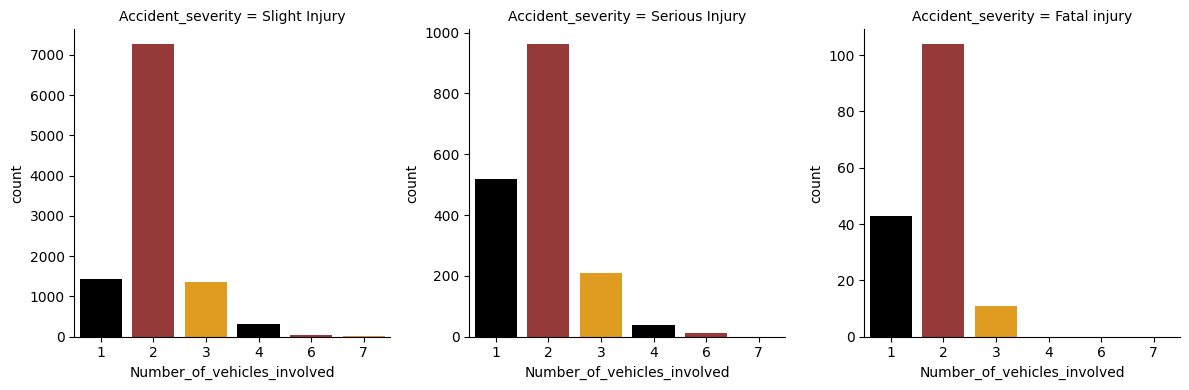

In [19]:
# creating a facet grid with columns as survived=0 and survived=1
grid = sns.FacetGrid(data=df, col='Accident_severity', height=4, aspect=1, sharey=False)
# mapping bar plot and the data on to the grid
grid.map(sns.countplot, 'Number_of_vehicles_involved', palette=['black', 'brown', 'orange'])
plt.show()

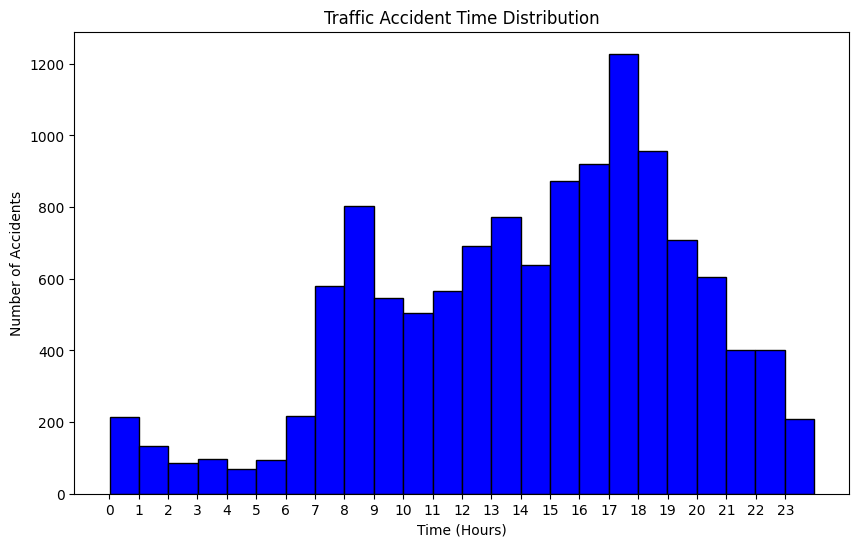

In [20]:
df['TimeInSeconds'] = df['Time'].apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)


plt.figure(figsize=(10,6))
plt.hist(df['TimeInSeconds'], bins=24, color='blue', edgecolor='black')
plt.title('Traffic Accident Time Distribution')
plt.xlabel('Time (Hours)')
plt.ylabel('Number of Accidents')
plt.xticks(range(0, 24 * 3600, 3600), range(24))
plt.show()

In [21]:
# dropping columns that can cause imbalance while imputation
lists = ['Vehicle_driver_relation', 'Work_of_casuality', 'Fitness_of_casuality', 
         'Day_of_week', 'Casualty_severity', 'Time', 'Sex_of_driver', 
         'Educational_level', 'Defect_of_vehicle', 'Owner_of_vehicle', 
         'Service_year_of_vehicle', 'Road_surface_type', 'Sex_of_casualty']

df.drop(columns=lists, inplace=True, errors='ignore')

In [22]:
df.shape

(12316, 20)

In [23]:
df.columns

Index(['Age_band_of_driver', 'Driving_experience', 'Type_of_vehicle',
       'Area_accident_occured', 'Lanes_or_Medians', 'Road_allignment',
       'Types_of_Junction', 'Road_surface_conditions', 'Light_conditions',
       'Weather_conditions', 'Type_of_collision',
       'Number_of_vehicles_involved', 'Number_of_casualties',
       'Vehicle_movement', 'Casualty_class', 'Age_band_of_casualty',
       'Pedestrian_movement', 'Cause_of_accident', 'Accident_severity',
       'TimeInSeconds'],
      dtype='object')

### Filling missing values

In [24]:
# fill missing values with mean column values
df['Driving_experience'].fillna(df['Driving_experience'].mode()[0], inplace=True)
df['Age_band_of_driver'].fillna(df['Age_band_of_driver'].mode()[0], inplace=True)
df['Type_of_vehicle'].fillna(df['Type_of_vehicle'].mode()[0], inplace=True)
df['Area_accident_occured'].fillna(df['Area_accident_occured'].mode()[0], inplace=True)
df['Road_allignment'].fillna(df['Road_allignment'].mode()[0], inplace=True)
df['Type_of_collision'].fillna(df['Type_of_collision'].mode()[0], inplace=True)
df['Vehicle_movement'].fillna(df['Vehicle_movement'].mode()[0], inplace=True)
df['Lanes_or_Medians'].fillna(df['Lanes_or_Medians'].mode()[0], inplace=True)
df['Types_of_Junction'].fillna(df['Types_of_Junction'].mode()[0], inplace=True)

In [25]:
df.isnull().sum()

Age_band_of_driver             0
Driving_experience             0
Type_of_vehicle                0
Area_accident_occured          0
Lanes_or_Medians               0
Road_allignment                0
Types_of_Junction              0
Road_surface_conditions        0
Light_conditions               0
Weather_conditions             0
Type_of_collision              0
Number_of_vehicles_involved    0
Number_of_casualties           0
Vehicle_movement               0
Casualty_class                 0
Age_band_of_casualty           0
Pedestrian_movement            0
Cause_of_accident              0
Accident_severity              0
TimeInSeconds                  0
dtype: int64

In [26]:
target_count = df['Accident_severity'].value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

Class 0: 10415
Class 1: 1743
Proportion: 5.98 : 1


### Encoding

In [27]:
from sklearn.preprocessing import LabelEncoder          
LE = LabelEncoder()
df=df.apply(LE.fit_transform)                            

In [28]:
plt.figure(figsize=[25,15])
sns.heatmap(df.corr(),annot=True)

<Axes: >

In [29]:
for col in df.select_dtypes(include='object'):
    if df[col].nunique() <= 22:
        sns.countplot(y=col, data=df)
        plt.show()

### Upsampling

In [30]:
x = df.drop('Accident_severity', axis=1)
y = df['Accident_severity']

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=42)
print(xtrain.shape, xtest.shape, ytrain.shape, ytest.shape)

(8621, 19) (3695, 19) (8621,) (3695,)


In [31]:


counter = Counter(ytrain)

print("=============================")

for k,v in counter.items():
    per = 100*v/len(ytrain)
    print(f"Class= {k}, n={v} ({per:.2f}%)")

oversample = SMOTE()
xtrain, ytrain = oversample.fit_resample(xtrain, ytrain)

counter = Counter(ytrain)

print("=============================")

for k,v in counter.items():
    per = 100*v/len(ytrain)
    print(f"Class= {k}, n={v} ({per:.2f}%)")

print("=============================")

print("Upsampled data shape: ", xtrain.shape, ytrain.shape)

Class= 2, n=7324 (84.96%)
Class= 1, n=1191 (13.82%)
Class= 0, n=106 (1.23%)
Class= 2, n=7324 (33.33%)
Class= 1, n=7324 (33.33%)
Class= 0, n=7324 (33.33%)
Upsampled data shape:  (21972, 19) (21972,)


### Splitting test and train data

In [32]:
x=df.drop(columns=["Accident_severity"])
y=df["Accident_severity"]

In [33]:
from sklearn.multiclass import OneVsRestClassifier
models = {
    "LogisticRegression": OneVsRestClassifier(LogisticRegression(C=1.0, solver='liblinear', penalty='l2')),
    "DecisionTreeClassifier": OneVsRestClassifier(DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=5)),
    "KNeighborsClassifier": OneVsRestClassifier(KNeighborsClassifier(n_neighbors=5, weights='distance', p=2)),
    "RandomForestClassifier": OneVsRestClassifier(RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=8)),
    "AdaBoostClassifier": OneVsRestClassifier(AdaBoostClassifier(n_estimators=200,learning_rate=0.1)),
    "GradientBoostingClassifier": OneVsRestClassifier(GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5))
}

def plt_auc(ytest,ypred_proba):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(ytest == i, ypred_proba[:, i])
       
        roc_auc[i] = roc_auc_score(ytest == i, ypred_proba[:, i])

  
    plt.figure(figsize=(10, 6))
    for i, color in zip(range(3), ['aqua', 'darkorange', 'cornflowerblue']):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

ROC AUC Score: 0.62
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
           1       0.00      0.00      0.00       363
           2       0.84      1.00      0.91      2064

    accuracy                           0.84      2464
   macro avg       0.28      0.33      0.30      2464
weighted avg       0.70      0.84      0.76      2464



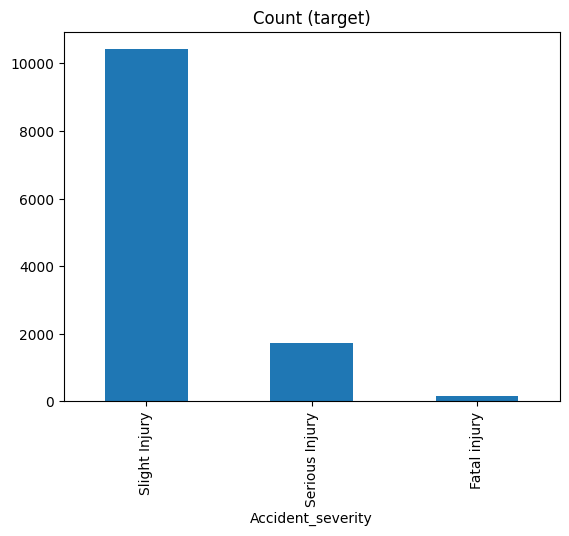

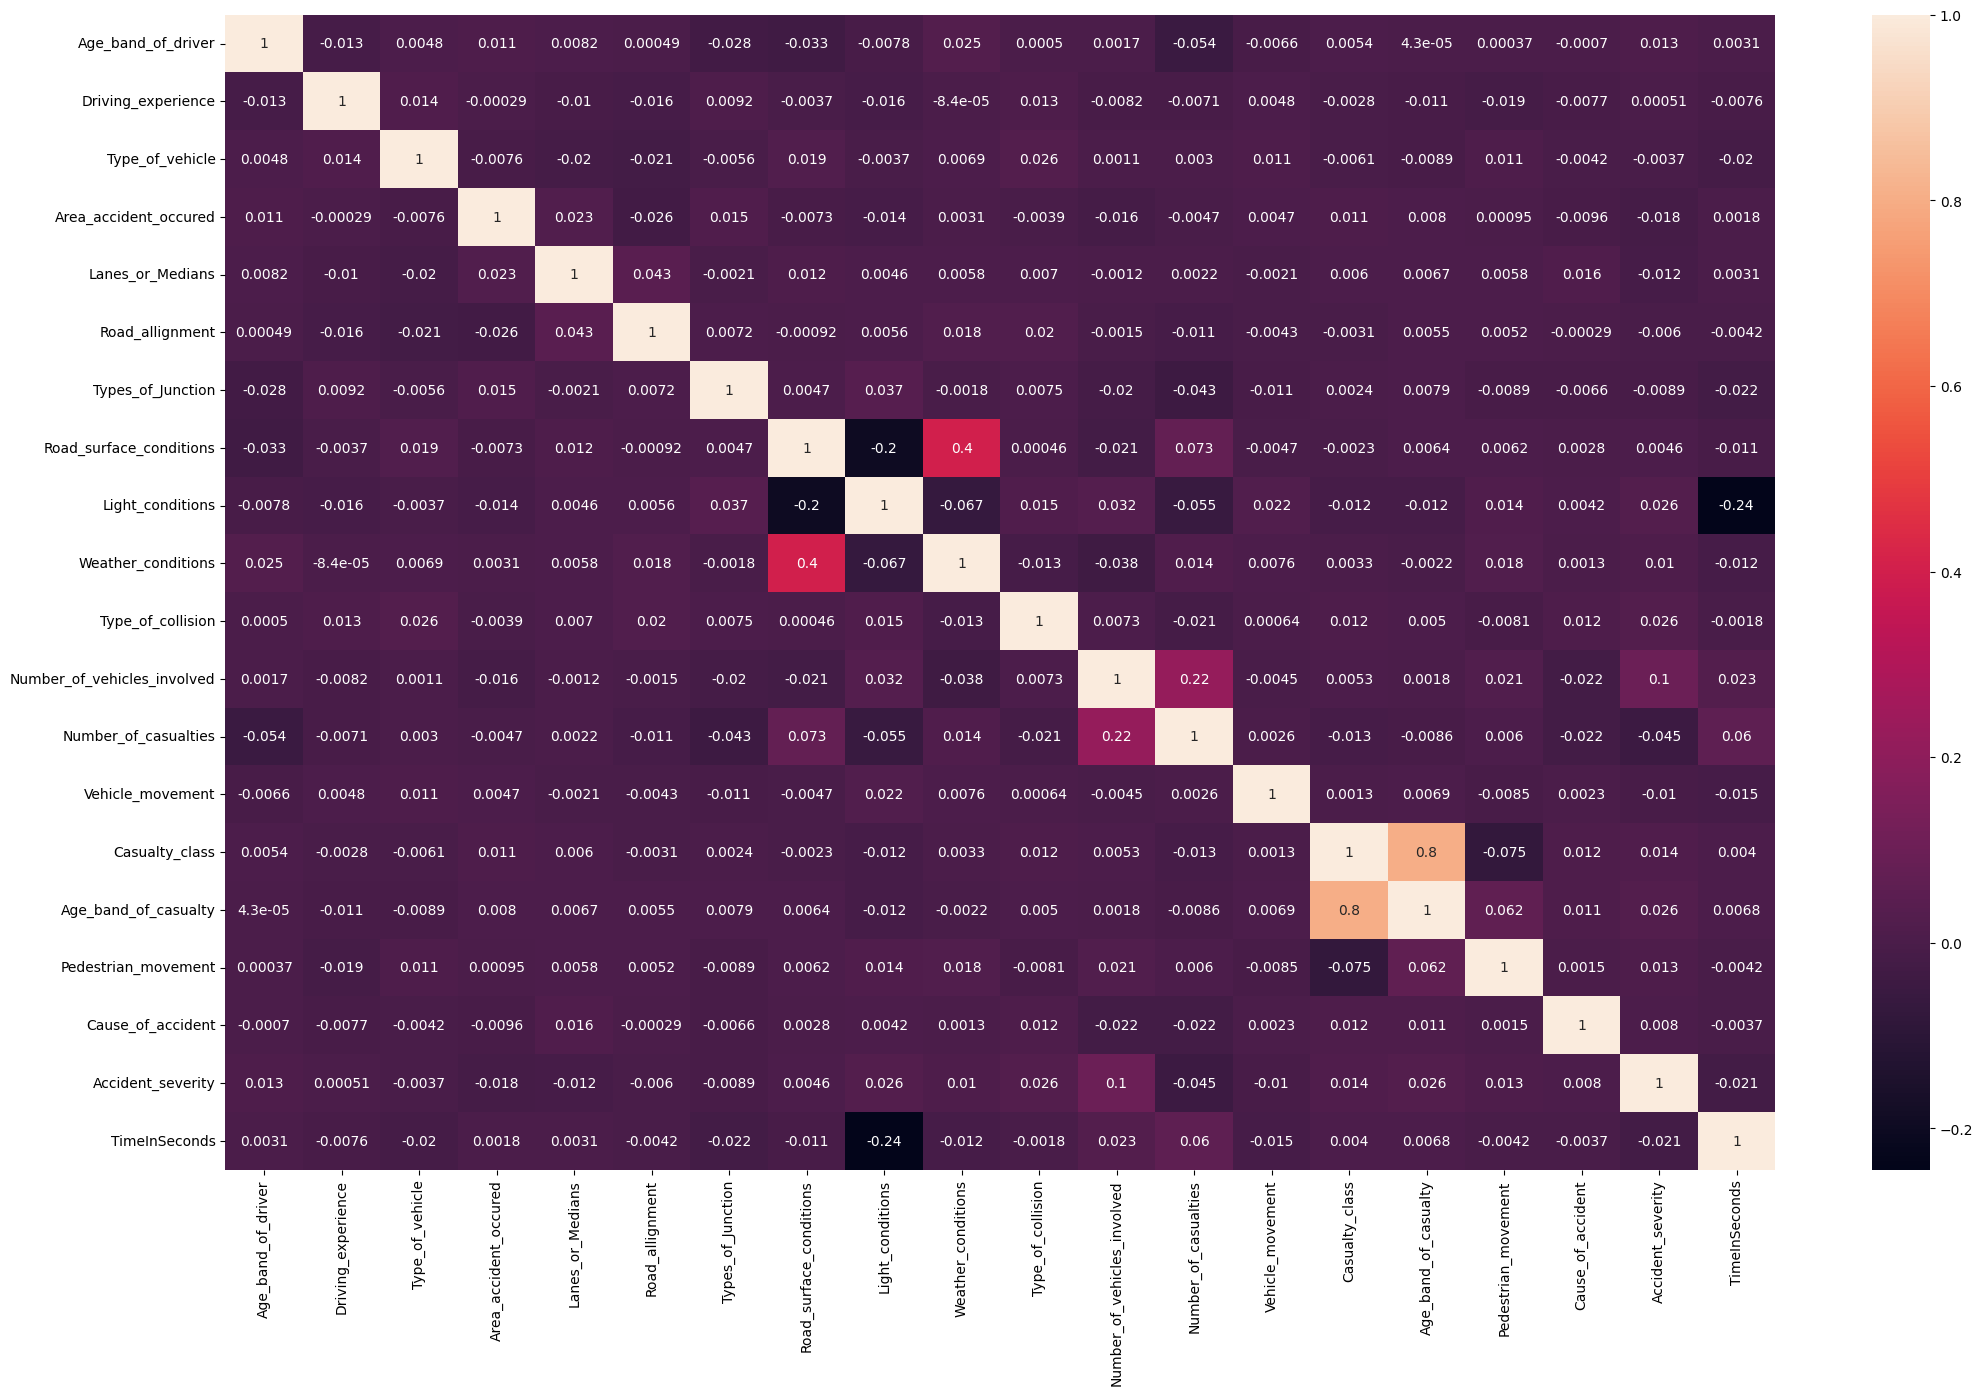

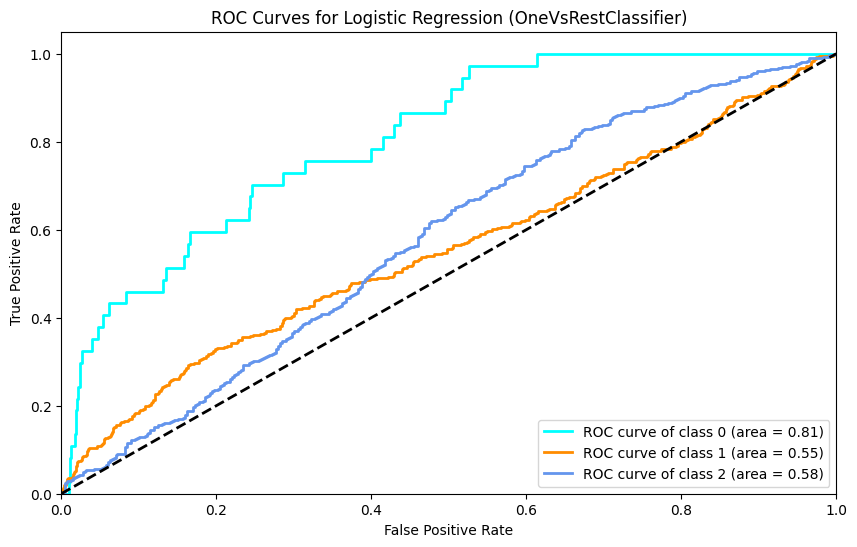

In [34]:


import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

# Sample data preparation (replace with your actual dataset)
# X = df.drop('target', axis=1)
# y = df['target']

# Assuming X and y are defined with your features and target
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Initialize Logistic Regression model with OneVsRestClassifier
model = OneVsRestClassifier(LogisticRegression(C=1.0, solver='liblinear', penalty='l2'))

# Cross-validate and predict probabilities
y_pred_proba = cross_val_predict(model, X_train, y_train, cv=5, method='predict_proba')

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_train, y_pred_proba, multi_class='ovr')
print(f"ROC AUC Score: {roc_auc:.2f}")

# Plot ROC curve
def plt_auc(ytest, ypred_proba):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(len(np.unique(ytest))):
        fpr[i], tpr[i], _ = roc_curve(ytest == i, ypred_proba[:, i])
        roc_auc[i] = roc_auc_score(ytest == i, ypred_proba[:, i])

    plt.figure(figsize=(10, 6))
    for i, color in zip(range(len(np.unique(ytest))), ['aqua', 'darkorange', 'cornflowerblue']):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.title('ROC Curves for Logistic Regression (OneVsRestClassifier)')
    plt.show()

# Fit the model on the training set
model.fit(X_train, y_train)
# Predict probabilities on the test set
y_test_pred_proba = model.predict_proba(X_test)
y_pred = model.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

# Plot ROC curve for the test set
plt_auc(y_test, y_test_pred_proba)

Dataset Loaded Successfully
       Time Day_of_week Age_band_of_driver Sex_of_driver   Educational_level  \
0  17:02:00      Monday              18-30          Male   Above high school   
1  17:02:00      Monday              31-50          Male  Junior high school   
2  17:02:00      Monday              18-30          Male  Junior high school   
3   1:06:00      Sunday              18-30          Male  Junior high school   
4   1:06:00      Sunday              18-30          Male  Junior high school   

  Vehicle_driver_relation Driving_experience      Type_of_vehicle  \
0                Employee              1-2yr           Automobile   
1                Employee         Above 10yr  Public (> 45 seats)   
2                Employee              1-2yr      Lorry (41?100Q)   
3                Employee             5-10yr  Public (> 45 seats)   
4                Employee              2-5yr                  NaN   

  Owner_of_vehicle Service_year_of_vehicle  ... Vehicle_movement  \
0       

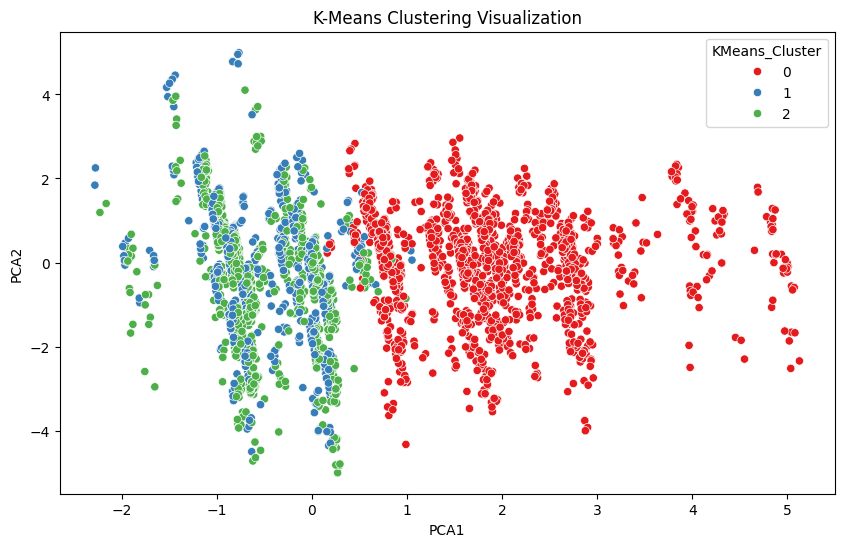

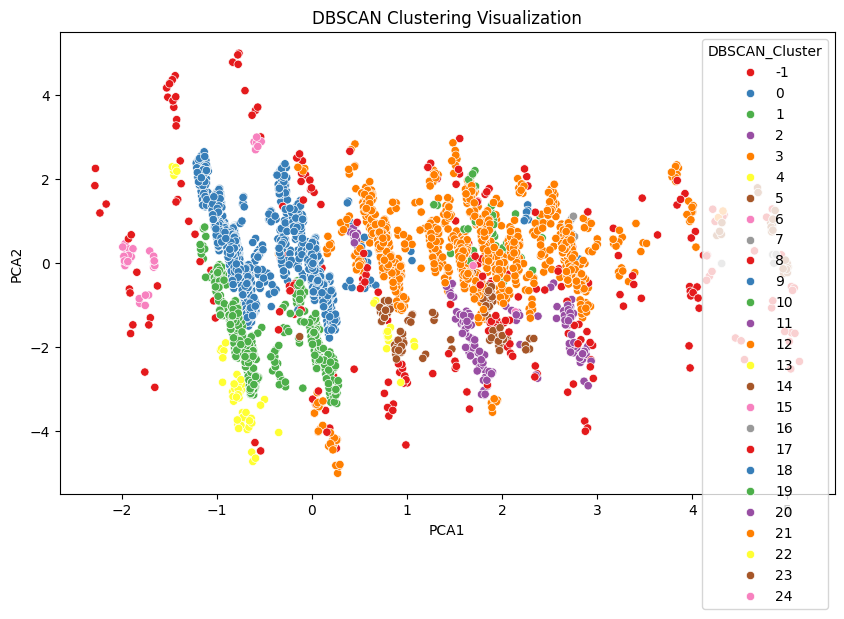


K-Means Cluster Distribution:
KMeans_Cluster
2    4306
1    3986
0    2929
Name: count, dtype: int64

DBSCAN Cluster Distribution:
DBSCAN_Cluster
 0     6822
 3     2213
 1     1154
-1      266
 10     174
 2      148
 5      125
 4       63
 6       41
 12      40
 16      34
 14      25
 11      17
 13      16
 17      12
 8       10
 7        8
 9        7
 24       7
 21       7
 22       6
 20       6
 19       5
 18       5
 23       5
 15       5
Name: count, dtype: int64
Clustered data saved to 'RTA_Clustered_Data.csv'


In [35]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data_path = 'datasetroad/RTA Dataset.csv'  # Replace with your dataset path
df = pd.read_csv(data_path)

# Display the first few rows of the dataset
print("Dataset Loaded Successfully")
print(df.head())

# Selected Features for Clustering
selected_features = [
    'Accident_severity', 'Weather_conditions', 'Road_surface_conditions',
    'Light_conditions', 'Number_of_vehicles_involved',
    'Type_of_collision', 'Age_band_of_driver', 'Type_of_vehicle'
]

# Filter the dataset for selected features
data = df[selected_features]

# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())

# Handle missing values (Drop or Impute)
data = data.dropna()  # Dropping rows with missing values

# Encode categorical variables
label_encoders = {}
for col in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Scale the features
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Apply K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_labels = kmeans.fit_predict(data_scaled)
data['KMeans_Cluster'] = kmeans_labels

# Apply DBSCAN Clustering
dbscan = DBSCAN(eps=1.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(data_scaled)
data['DBSCAN_Cluster'] = dbscan_labels

# Dimensionality Reduction for Visualization
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_scaled)
data['PCA1'] = data_pca[:, 0]
data['PCA2'] = data_pca[:, 1]

# Visualization: K-Means Clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='KMeans_Cluster', data=data, palette='Set1')
plt.title('K-Means Clustering Visualization')
plt.show()

# Visualization: DBSCAN Clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='DBSCAN_Cluster', data=data, palette='Set1')
plt.title('DBSCAN Clustering Visualization')
plt.show()

# Summary of Clustering Results
print("\nK-Means Cluster Distribution:")
print(data['KMeans_Cluster'].value_counts())

print("\nDBSCAN Cluster Distribution:")
print(data['DBSCAN_Cluster'].value_counts())

# Save the clustered data to a new CSV file
data.to_csv('datasetroad/RTA_Clustered_Data.csv', index=False)
print("Clustered data saved to 'RTA_Clustered_Data.csv'")


In [36]:
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

# Load dataset
df = pd.read_csv("datasetroad/RTA Dataset.csv")  # Ensure you provide the correct dataset path

# Drop rows with missing target values
df = df.dropna(subset=["Accident_severity"])

# Select relevant features
features = [
    "Day_of_week", "Age_band_of_driver", "Sex_of_driver",
    "Driving_experience", "Type_of_vehicle", "Vehicle_movement",
    "Cause_of_accident"
]
target = "Accident_severity"

# Encode categorical variables
label_encoders = {}
for col in features + [target]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# Split dataset
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Save the trained model and encoders
with open("accident_severity_model.pkl", "wb") as model_file:
    pickle.dump(model, model_file)

with open("label_encoders.pkl", "wb") as encoder_file:
    pickle.dump(label_encoders, encoder_file)

print("Model and encoders saved successfully.")


Model and encoders saved successfully.


In [37]:
import pickle
import pandas as pd

# Load the saved model and encoders
model_filename = "accident_severity_model.pkl"
encoder_filename = "label_encoders.pkl"

with open(model_filename, "rb") as model_file:
    loaded_model = pickle.load(model_file)

with open(encoder_filename, "rb") as encoder_file:
    loaded_encoders = pickle.load(encoder_file)

# Example new data for prediction (must match feature names from training)
new_data = pd.DataFrame([{
    "Day_of_week": "Sunday",
    "Age_band_of_driver": "18-30",
    "Sex_of_driver": "Male",
    "Driving_experience": "1-2yr",
    "Type_of_vehicle": "Automobile",
    "Vehicle_movement": "Going straight",
    "Cause_of_accident": "Overspeed"
}])

# Features used in training
features = [
    "Day_of_week", "Age_band_of_driver", "Sex_of_driver",
    "Driving_experience", "Type_of_vehicle", "Vehicle_movement",
    "Cause_of_accident"
]

# Encode new data using the saved label encoders
for col in features:
    new_data[col] = loaded_encoders[col].transform(new_data[col].astype(str))
# Predict accident severity
predicted_severity = loaded_model.predict(new_data)

# Decode prediction back to original labels
predicted_label = loaded_encoders["Accident_severity"].inverse_transform(predicted_severity)

print("Predicted Accident Severity:", predicted_label[0])




Predicted Accident Severity: Slight Injury
